# Multi target regression from ROOT file

### Modules

In [78]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import pandas as pd
import numpy as np
import os
import h5py
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

In [79]:
from __future__ import division
import numpy as np
import pandas
import math
import os
import types
import h5py
from six.moves import cPickle as pickle
from pathlib import Path
import pandas as pd

from sklearn.metrics import roc_auc_score

from lumin.nn.training.fold_train import *
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.data.fold_yielder import *
from lumin.nn.ensemble.ensemble import Ensemble
from lumin.nn.metrics.class_eval import *
from lumin.plotting.data_viewing import *
from lumin.utils.misc import *
from lumin.optimisation.threshold import binary_class_cut
from lumin.optimisation.hyper_param import fold_lr_find
from lumin.evaluation.ams import calc_ams
from lumin.nn.callbacks.cyclic_callbacks import *
from lumin.nn.callbacks.model_callbacks import SWA
from lumin.plotting.results import *
from lumin.plotting.plot_settings import PlotSettings
from lumin.plotting.interpretation import *
from lumin.data_processing.hep_proc import *
from lumin.data_processing.pre_proc import *
from lumin.data_processing.file_proc import *
from lumin.utils.misc import *

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [80]:
from pathlib import Path
PATH = Path('./data')

## Data preparation

### Data import from ROOT file 

In [81]:
import uproot
df = uproot.open(PATH/'signal.root')['tree'].pandas.df()

In [82]:
df.head()

,t_0_pT,t_0_eta,t_0_phi,t_0_mass,t_1_pT,t_1_eta,t_1_phi,t_1_mass,b_0_pT,b_0_eta,...,gen_h_bb_eta,gen_h_bb_phi,gen_h_bb_E,gen_h_tt_pT,gen_h_tt_eta,gen_h_tt_phi,gen_h_tt_E,gen_mctMatch,gen_weight,gen_target
0,36.850742,-1.301508,-0.449490,3.583080e+00,88.756241,-0.045828,0.801673,0.105658,101.773132,-0.621864,...,-0.366014,-2.261545,193.133926,167.054816,-0.364203,0.617325,217.716858,1.0,1.0,1.0
1,44.549965,1.641584,2.540022,1.228315e+00,68.820755,1.131779,-2.750534,0.105658,198.545624,1.155151,...,1.094840,-0.055264,477.111084,205.618939,1.476620,3.140846,489.813568,1.0,1.0,1.0
2,32.312160,0.225592,-2.485713,7.742898e-01,73.520073,0.495276,1.294261,0.105658,344.611084,0.085861,...,-0.034175,-0.278533,399.206879,66.369413,0.820306,1.702539,154.017578,1.0,1.0,1.0
3,55.896526,-1.680148,1.079537,4.889964e+00,32.492466,-1.598684,2.668608,0.105658,92.599792,-2.158637,...,-1.933018,-0.814522,517.224487,141.165349,-1.903520,2.270204,499.970337,1.0,1.0,1.0
4,47.391769,0.881903,2.025714,9.536743e-07,95.349663,0.173650,2.977873,0.105658,154.887131,0.073108,...,-0.028465,-0.835442,382.160492,253.092701,0.351680,2.796669,296.538849,1.0,1.0,1.0


In [83]:
df.drop(columns=['t_1_mass'], inplace=True)

In [84]:
df = df[df.gen_mctMatch == 1]; len(df)

61405

In [85]:
df['gen_h_tt_delta'] = df['h_tt_mass']-125

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


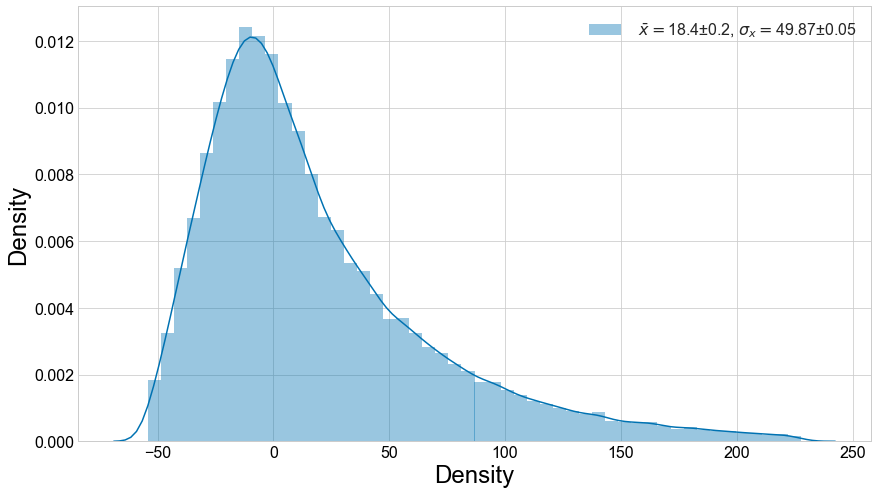

In [86]:
plot_feat(df, 'gen_h_tt_delta')

### Preprocessing

In [87]:
proc_event(df, cartesian=True, keep_feats=['mPT_pT'])

Converting to Cartesian coordinates


In [88]:
targ_feats = ['gen_t_0_px', 'gen_t_0_py', 'gen_t_0_pz', 'gen_t_1_px', 'gen_t_1_py', 'gen_t_1_pz']
gen_feats = [f for f in df.columns if 'gen_' in f]
cat_feats = [f for f in df.columns if f.startswith('n') if f != 'nPhotons']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

3 ['nJets', 'nBJets', 'nTauJets']
56 ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'hT', 'sT', 'centrality', 'eVis', 'minJetPT', 'meanJetPT', 'maxJetPT', 'minJetMass', 'meanJetMass', 'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'nPhotons', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA', 'dShapeA', 'sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 'upsilonP', 'dShapeP', 'b_0_px', 'b_0_py', 'b_0_pz', 'diH_px', 'diH_py', 'diH_pz', 't_1_px', 't_1_py', 't_1_pz', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'mPT_px', 'mPT_py', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 't_0_px', 't_0_py', 't_0_pz', 'mPT_pT']


In [89]:
df.loc[df.nJets >= 5, 'nJets'] = 4
df.loc[df.nBJets >= 5, 'nBJets'] = 4

In [90]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[cat_feats].values)

In [91]:
for f in cat_feats:
    s = set(df[f])
    print(f, len(s), s)

nJets 2 {3.0, 4.0}
nBJets 3 {2.0, 3.0, 4.0}
nTauJets 3 {1.0, 2.0, 3.0}


#### Train-validation split 

In [92]:
for k in set(df.gen_strat_key):
    l = len(df[df.gen_strat_key == k])
    if l < 2: print(df[df.gen_strat_key == k][cat_feats])

In [93]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [94]:
df.columns[df.isna().any()].tolist()

[]

In [95]:
from sklearn.model_selection import train_test_split 
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key)

In [19]:
from lumin.utils.data import check_val_set
check_val_set(train_df, val_df)


AUC for train-validation discrimination = 0.5022824488605375
Top 10 most important features are:
   index      Feature  Importance
0      0     minJetPT    0.004323
1      1     b_1_mass    0.003942
2      2       b_0_py    0.003687
3      3       b_0_pz    0.003179
4      4      h_bb_py    0.002797
5      5       diH_py    0.002416
6      6  meanJetMass    0.001907
7      7       mPT_pT    0.001653
8      8       b_0_px    0.001653
9      9       b_1_pz    0.001526


In [96]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(train_df, cont_feats, PATH)

In [ ]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])

In [97]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df)

### Conversion to fold file 

In [98]:
from lumin.data_processing.file_proc import df2foldfile

In [99]:
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feats,
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

Saving fold: 0 with 4915 events
Saving fold: 1 with 4914 events
Saving fold: 2 with 4914 events
Saving fold: 3 with 4914 events
Saving fold: 4 with 4913 events
Saving fold: 5 with 4913 events
Saving fold: 6 with 4912 events
Saving fold: 7 with 4912 events
Saving fold: 8 with 4909 events
Saving fold: 9 with 4908 events


In [100]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, targ_feats=targ_feats,
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

Saving fold: 0 with 1230 events
Saving fold: 1 with 1230 events
Saving fold: 2 with 1229 events
Saving fold: 3 with 1228 events
Saving fold: 4 with 1227 events
Saving fold: 5 with 1228 events
Saving fold: 6 with 1228 events
Saving fold: 7 with 1227 events
Saving fold: 8 with 1229 events
Saving fold: 9 with 1225 events


In [102]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = HEPAugFoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats, targ_feats)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [103]:
def get_df(fold):
    df = pd.DataFrame(fold['inputs'], columns=train_feats)
    return df.append(pd.DataFrame(fold["targets"], columns=targ_feats))


/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


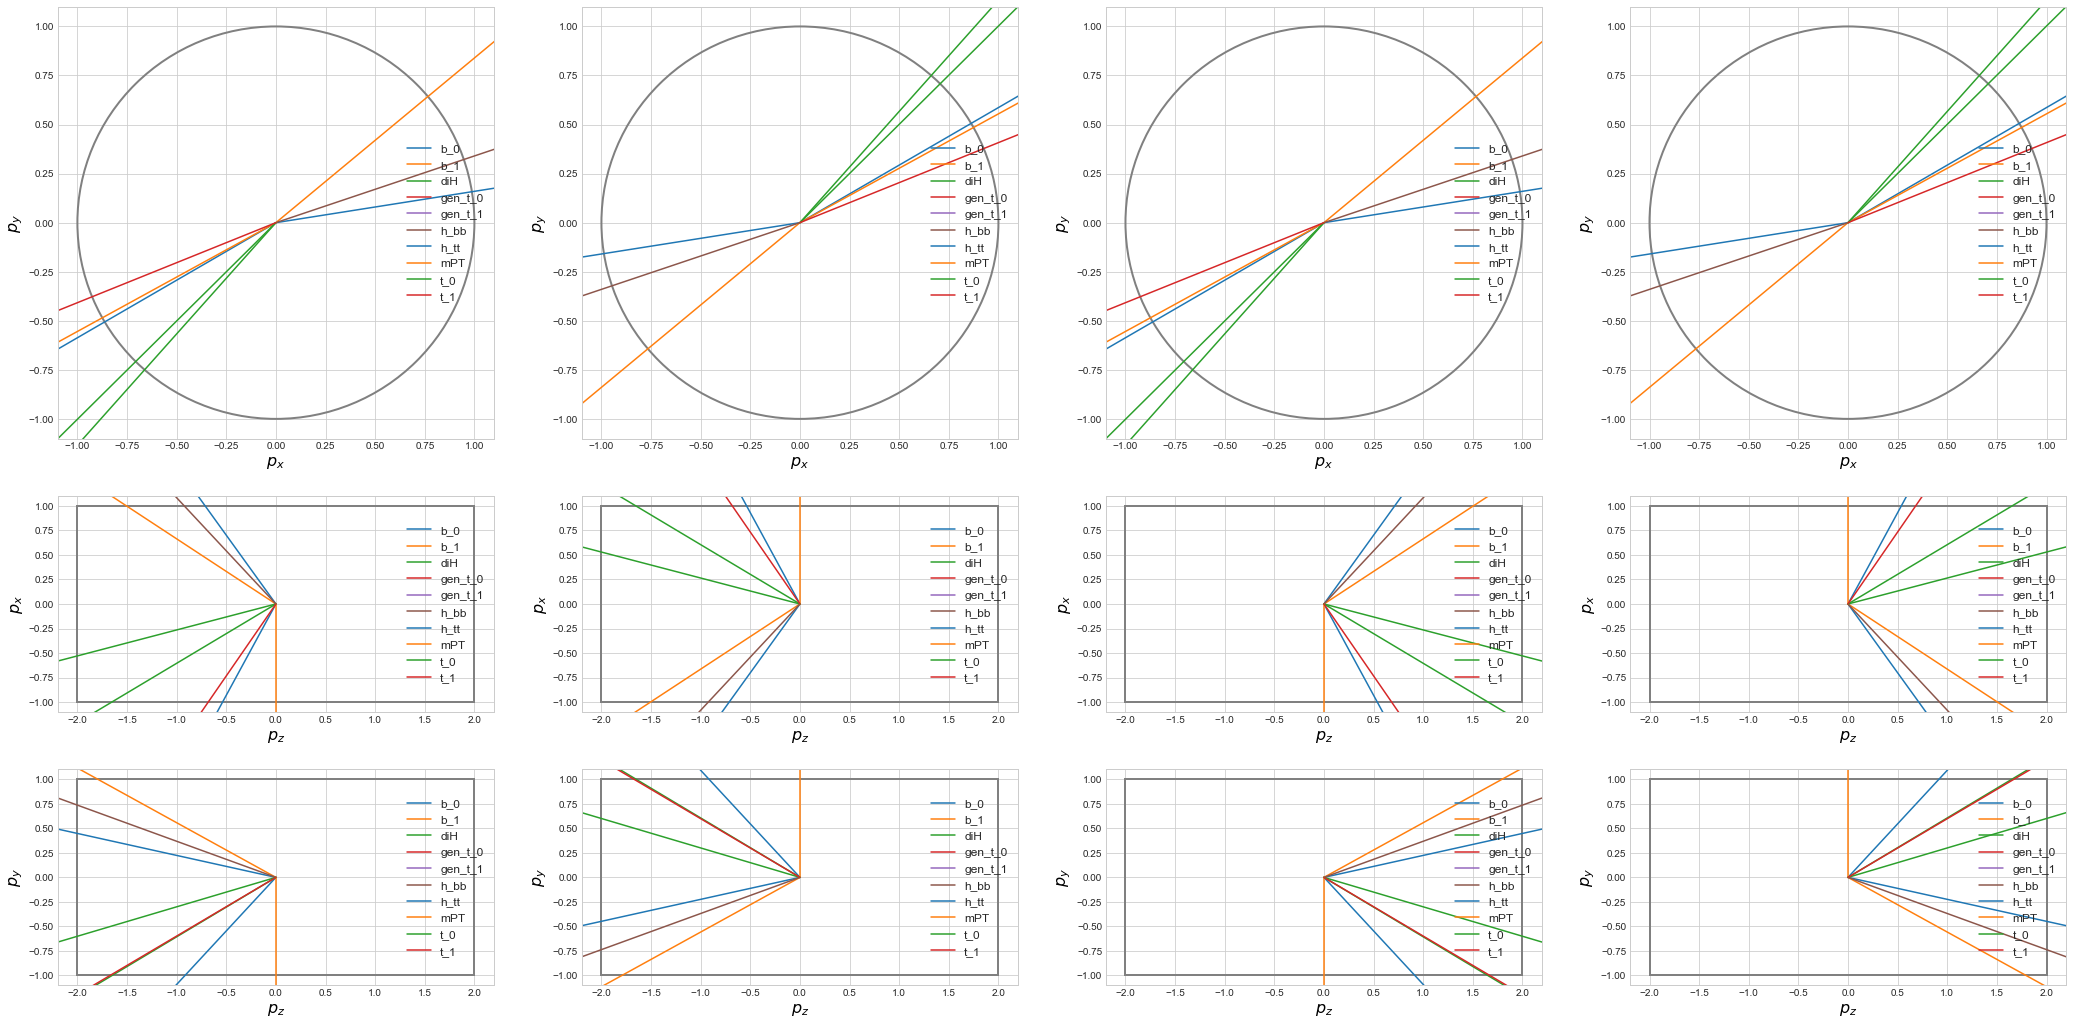

In [105]:
from lumin.plotting.data_viewing import compare_events

id=3
aug_ranges = [range(4)]
for aug_range in aug_ranges:
    compare_events([get_df(train_fy.get_test_fold(0,i))[id:id+1] for i in aug_range])

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


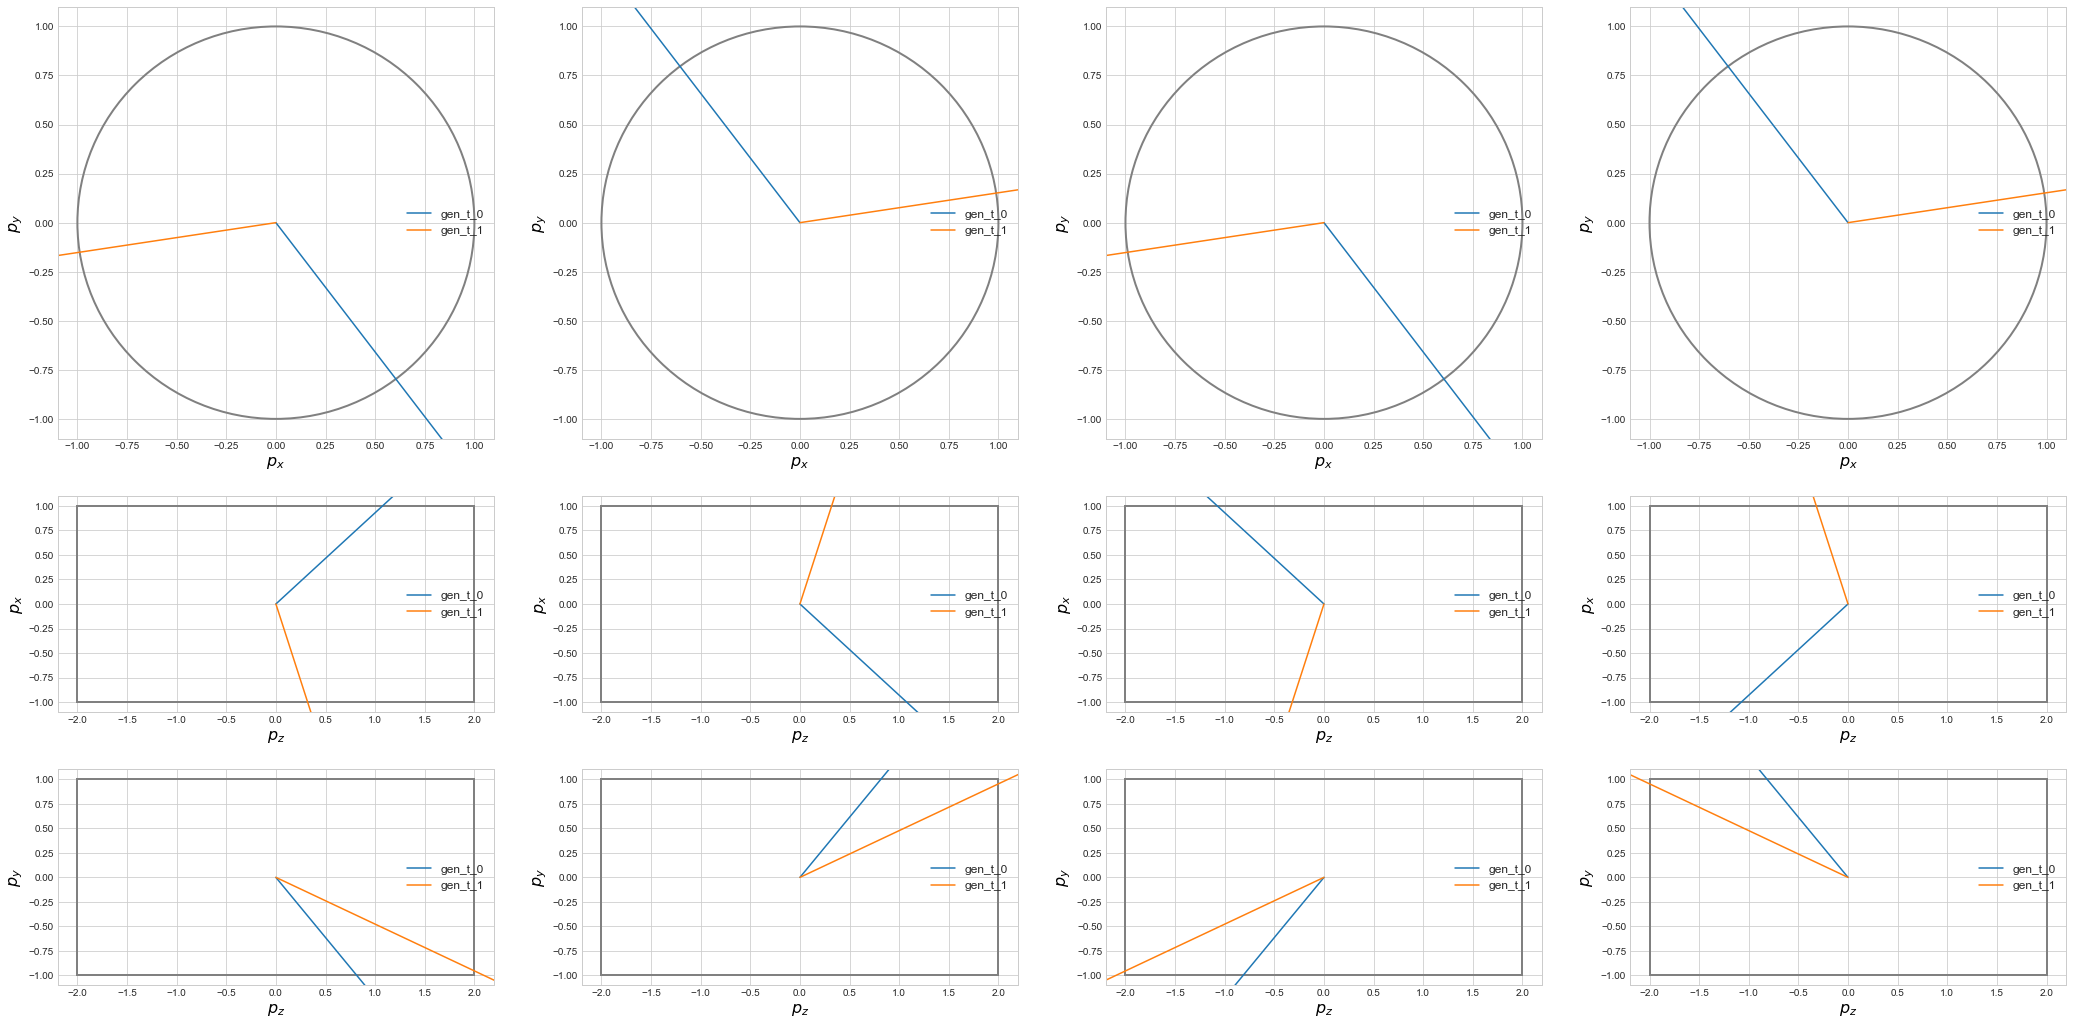

In [71]:
from lumin.plotting.data_viewing import compare_events

id=3
aug_ranges = [range(4)]
for aug_range in aug_ranges:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['targets'], columns=targ_feats)[id:id+1] for i in aug_range])

## Feature selection

In [30]:
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

49124 candidates loaded


/Users/giles/cernbox/lumin/lumin/nn/data/fold_yielder.py:117: UserWarning: weights not found in file
  warnings.warn(f"{weight_name} not found in file")


,t_0_mass,b_0_mass,b_1_mass,h_tt_mass,h_bb_mass,diH_mass,hT,sT,centrality,eVis,...,mPT_pT,nJets,nBJets,nTauJets,gen_target_0,gen_target_1,gen_target_2,gen_target_3,gen_target_4,gen_target_5
0,4.572579,14.773635,15.750826,141.209366,105.581955,444.546143,310.668610,462.678955,0.188692,2102.506348,...,62.035385,1.0,0.0,0.0,-97.506371,9.881627,113.857925,-36.353508,114.670204,83.769623
1,6.481071,17.333611,13.689518,169.122940,118.178101,707.283752,640.870300,817.193420,0.705473,1036.291138,...,82.942993,1.0,0.0,0.0,94.732613,-160.262497,-293.683258,131.860916,-64.445015,-120.726166
2,3.239596,55.828133,5.619412,154.692963,137.934982,600.870972,1043.916504,1159.341675,0.757641,1454.662354,...,52.766102,1.0,0.0,0.0,13.850382,-18.856304,-59.743969,-84.203552,-28.879000,21.820307
3,1.223286,8.138877,4.841931,136.186935,94.351402,278.584595,323.552032,413.504150,0.868096,419.516571,...,47.092865,1.0,0.0,0.0,42.178150,-55.612114,45.349159,-72.611099,-11.065954,23.214909
4,1.248926,20.341696,8.956815,270.912048,105.061195,874.574829,492.088806,727.205627,0.424921,1209.699341,...,211.372223,1.0,0.0,0.0,-91.833885,-25.739769,-225.081741,-296.082123,81.666763,-411.797485


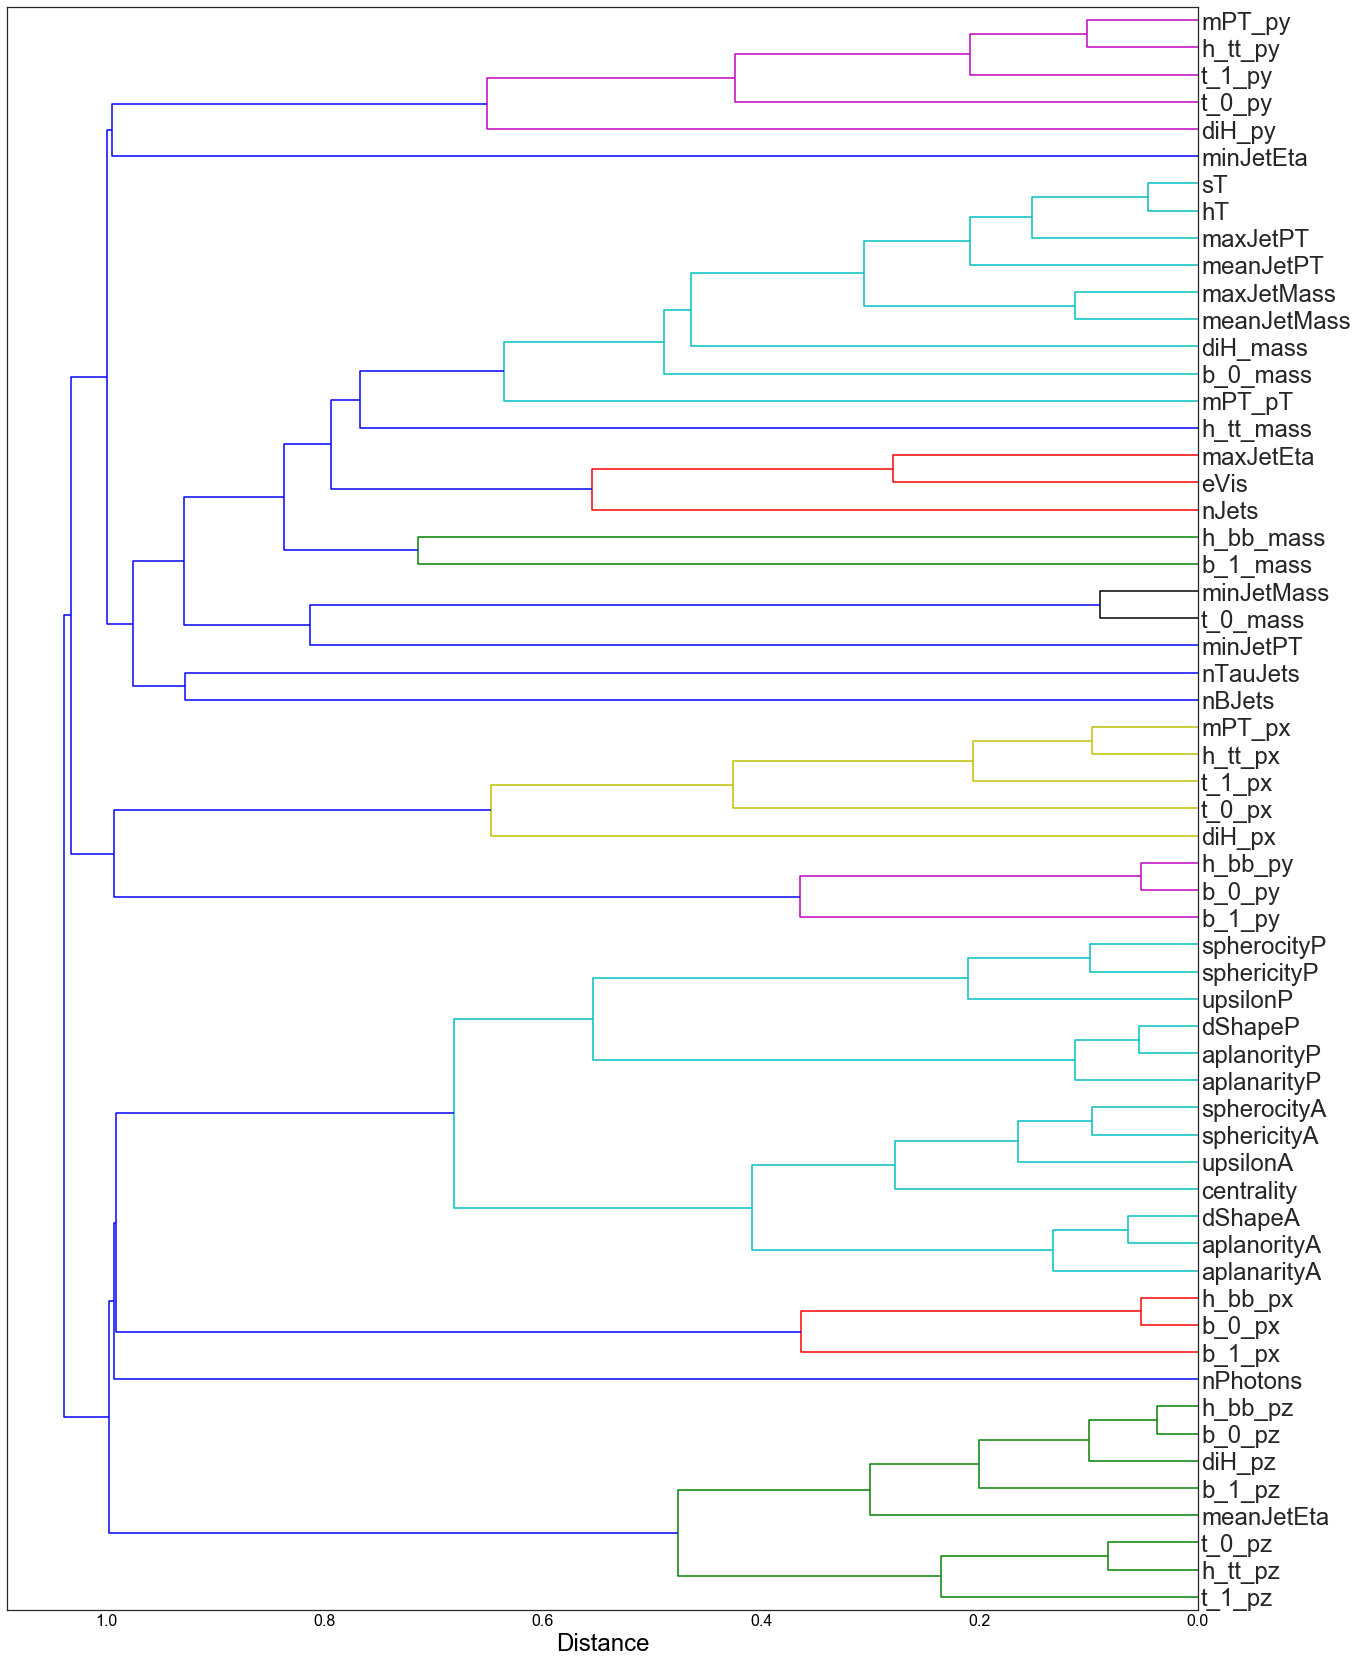

In [31]:
plot_dendrogram(train_df[train_feats])

In [32]:
df_trn, df_val = train_test_split(train_df, test_size=0.8)

In [33]:
vec_feats = []
for c in ['px', 'py', 'pz', 'mass']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats)

29

In [34]:
hl_feats = [f for f in train_feats if f not in vec_feats]; len(hl_feats)

30

In [35]:
targ_feats

['gen_t_0_px',
 'gen_t_0_py',
 'gen_t_0_pz',
 'gen_t_1_px',
 'gen_t_1_py',
 'gen_t_1_pz']

Optimising RF


Top ten most important features:
        Feature  Importance
0   meanJetEta    0.458692
1    maxJetEta    0.076006
2   centrality    0.052615
3    minJetEta    0.036531
4       mPT_pT    0.034953
5         eVis    0.031228
6  spherocityP    0.021502
7  aplanorityP    0.016482
8    meanJetPT    0.015379
9           sT    0.013594


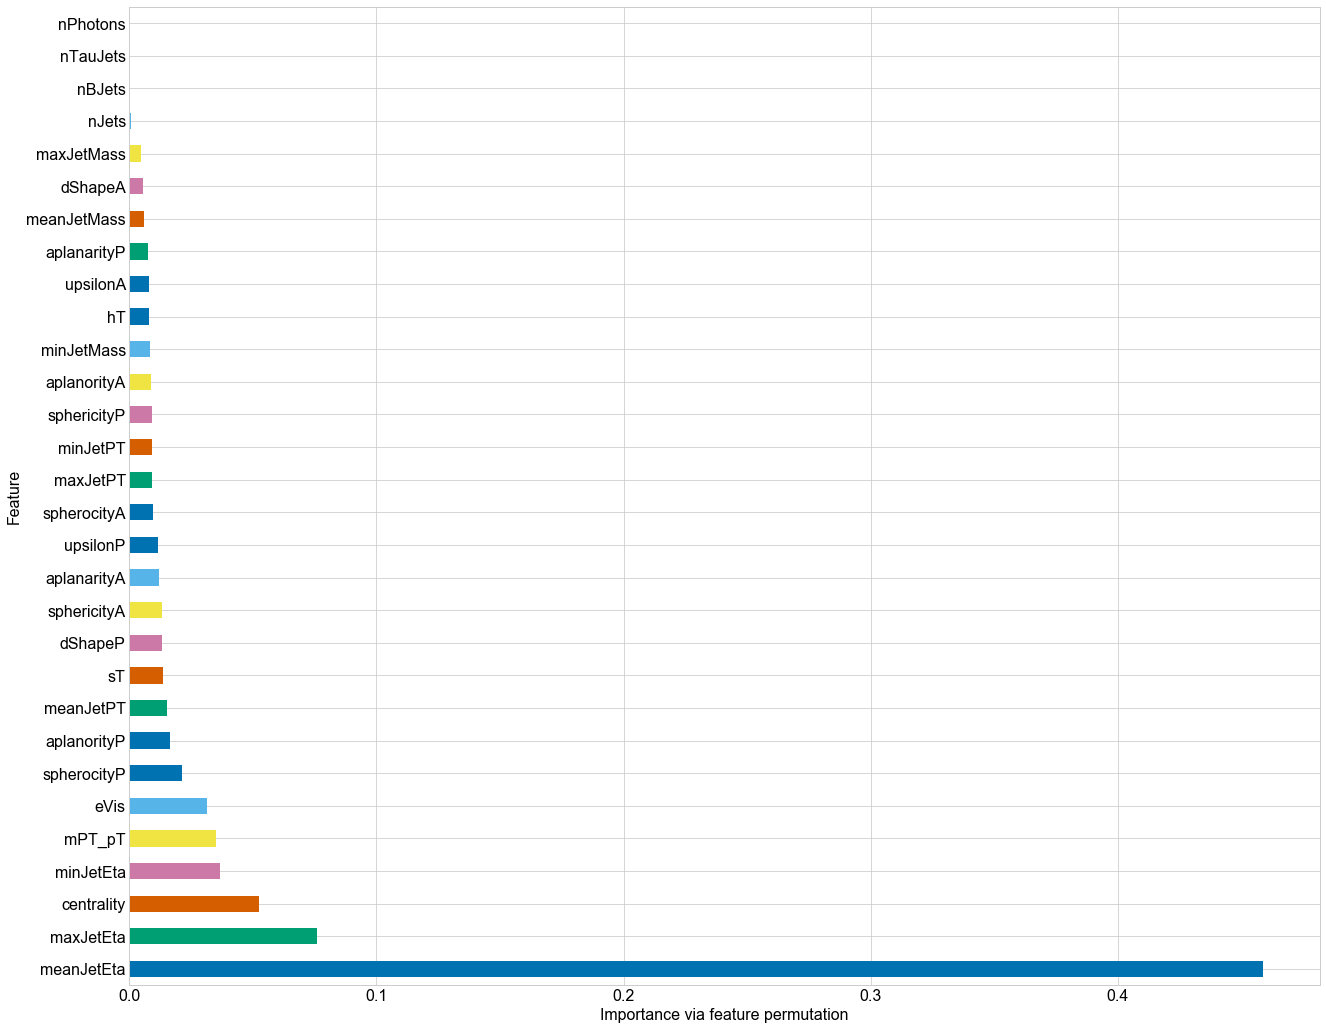


26 features found with importance greater than 0.001:
 ['meanJetEta', 'maxJetEta', 'centrality', 'minJetEta', 'mPT_pT', 'eVis', 'spherocityP', 'aplanorityP', 'meanJetPT', 'sT', 'dShapeP', 'sphericityA', 'aplanarityA', 'upsilonP', 'spherocityA', 'maxJetPT', 'minJetPT', 'sphericityP', 'aplanorityA', 'minJetMass', 'hT', 'upsilonA', 'aplanarityP', 'meanJetMass', 'dShapeA', 'maxJetMass']

Optimising new RF


Comparing RF scores, higher = better
All features:	0.27536
Top features:	0.27536


In [36]:
from lumin.optimisation.features import *
import_feats = rf_rank_features(df_trn, df_val, objective='regression', train_feats=hl_feats, cut=0.001,
                                targ_name=[f'gen_target_{i}' for i in range(len(targ_feats))])

In [37]:
from rfpimp import plot_corr_heatmap, feature_dependence_matrix, plot_dependence_heatmap

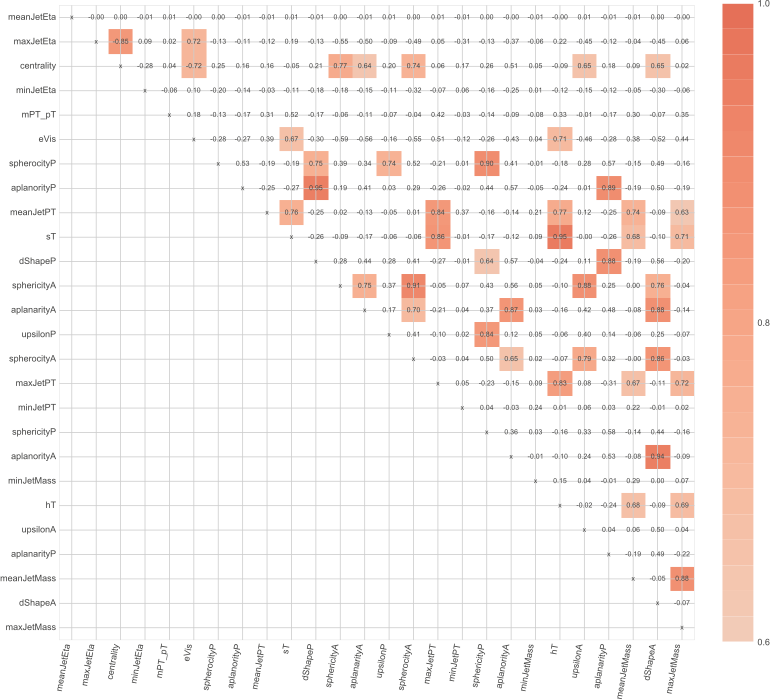

In [38]:
plot_corr_heatmap(df_trn[import_feats], figsize=(11,11), label_fontsize=9, value_fontsize=7)

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
D = feature_dependence_matrix(df_trn[import_feats], sort_by_dependence=False, rfmodel=RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True))

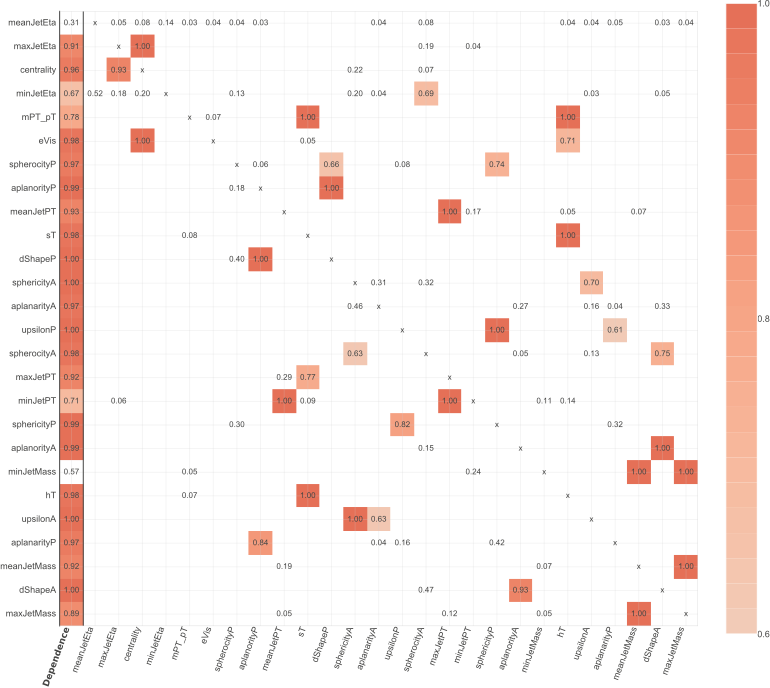

In [41]:
plot_dependence_heatmap(D, figsize=(11,10))

In [42]:
drop = ['dShapeP', 'aplanarityP', 'aplanorityA', 'upsilonA']

In [43]:
ignore_feats = [f for f in train_feats if f not in vec_feats + import_feats or f in drop];len(ignore_feats),  ignore_feats

(8,
 ['nPhotons',
  'aplanorityA',
  'upsilonA',
  'aplanarityP',
  'dShapeP',
  'nJets',
  'nBJets',
  'nTauJets'])

In [45]:
with open(PATH/'feats.pkl', 'wb') as fout:
    pickle.dump({'targ_feats': targ_feats, 'cont_feats': cont_feats, 'cat_feats': cat_feats, 'cat_maps': cat_maps, 'cat_szs': cat_szs, 'ignore_feats': ignore_feats}, fout)

## Train regressor

In [46]:
with open(PATH/'feats.pkl', 'rb') as fin:
    feats = pickle.load(fin)
    targ_feats = feats['targ_feats']
    cont_feats = feats['cont_feats']
    cat_feats = feats['cat_feats']    
    cat_maps = feats['cat_maps']    
    cat_szs = feats['cat_szs']    
    ignore_feats = feats['ignore_feats']
    train_feats = cont_feats + cat_feats
    
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)
with open(PATH/'output_pipe.pkl', 'rb') as fin:
    output_pipe = pickle.load(fin)

In [48]:
train_fy = HEPAugFoldYielder(h5py.File(PATH/'train.hdf5', "r+"), cont_feats, cat_feats, targ_feats=targ_feats)
train_fy.ignore(ignore_feats)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [52]:
use_conts = [f for f in cont_feats if f not in ignore_feats]
use_cats = [f for f in cat_feats if f not in ignore_feats]

In [53]:
for f in [f for f in cat_feats if f not in use_cats]: cat_szs.pop(f)

In [55]:
targets = train_fy.get_column("targets")

min_targs = np.min(targets, axis=0).reshape(targets.shape[1],1)
max_targs = np.max(targets, axis=0).reshape(targets.shape[1],1)

min_targs[min_targs > 0] *=0.8
min_targs[min_targs < 0] *=1.2
max_targs[max_targs > 0] *=1.2
max_targs[max_targs < 0] *=0.8

y_range = np.hstack((min_targs, max_targs)); y_range

array([[ -835.9635 ,  1157.7169 ],
       [ -674.2621 ,   736.24396],
       [-2135.481  ,  2159.9143 ],
       [ -795.7437 ,   850.8103 ],
       [ -797.36176,  1273.5232 ],
       [-1699.205  ,  1847.6505 ]], dtype=float32)

In [56]:
import torch.nn as nn
n_models = 1
patience = 2
max_epochs = 2

ensemble_size = 10
ensemble_mode = 'loss'

train_params = {'epochs' : 1, 'bs' : 128, 'verbose' : 0}
objective = 'regression'
model_args = {'act': 'swish'}
opt_args = {'eps':1e-08}
n_cont_in=len(use_conts)
cat_args = {'n_cat_in': len(use_cats), 'cat_szs': [cat_szs[f] for f in cat_szs], 'cat_names': [f for f in cat_szs]}

n_out = len(targ_feats)
model_builder = ModelBuilder(objective, n_cont_in=len(use_conts), n_out=n_out, cat_args=cat_args, y_range=y_range,
                             model_args=model_args, opt_args=opt_args, loss=nn.MSELoss)

print("\nTraining on", len(use_conts), " continuous features:", [var for var in use_conts])
print("\nTraining on", len(use_cats), " categorical features:", [var for var in use_cats])
print('\n Model:')
print(Model(model_builder))


Training on 51  continuous features: ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'hT', 'sT', 'centrality', 'eVis', 'minJetPT', 'meanJetPT', 'maxJetPT', 'minJetMass', 'meanJetMass', 'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'sphericityA', 'spherocityA', 'aplanarityA', 'dShapeA', 'sphericityP', 'spherocityP', 'aplanorityP', 'upsilonP', 'b_0_px', 'b_0_py', 'b_0_pz', 'diH_px', 'diH_py', 'diH_pz', 't_1_px', 't_1_py', 't_1_pz', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'mPT_px', 'mPT_py', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 't_0_px', 't_0_py', 't_0_pz', 'mPT_pT']

Training on 0  categorical features: []

 Model:
Model:
<bound method Module.parameters of Sequential(
  (0): Sequential(
    (0): CatEmbHead()
    (1): Sequential(
      (0): Linear(in_features=51, out_features=100, bias=True)
      (1): Swish()
    )
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=100, out_fea

LR finder took 3.230s 


/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


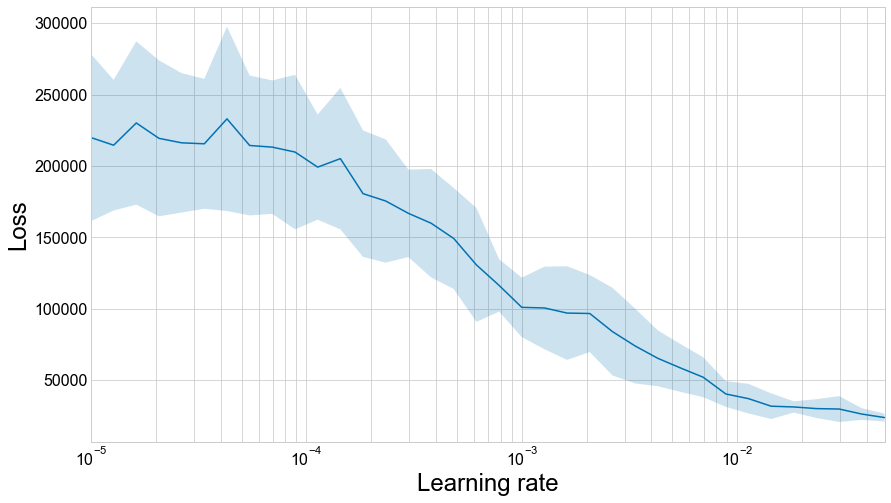

In [57]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, train_params['bs'], lr_bounds=[1e-5,1e-1])

In [65]:
def reg_proxy_func(df):
    df['pred'] = calc_pair_mass(df, (1.77682, 1.77682), {targ[targ.find('_t')+3:]: f'pred_{i}'  for i, targ in enumerate(targ_feats)})
    df['gen_target'] = 125

In [66]:
from lumin.nn.metrics.reg_eval import RegAsProxyPull
use_callbacks = [{'callback':CycleLR, 'kargs':{'lr_range': (0, 7e-3), 'cycle_mult':2}}]
eval_metrics = {'Pull': RegAsProxyPull(func=reg_proxy_func, use_pull=False)}
plots = ['history']

Training model 1 / 1


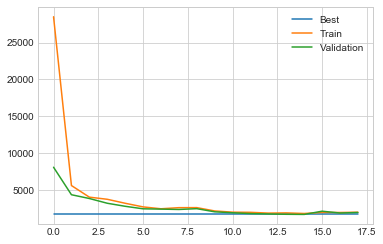

Scores are: {'loss': 1655.169921875, 'Pull': 39.46874912904867}
Fold took 7.534s


______________________________________
Training finished
Cross-validation took 7.538s 


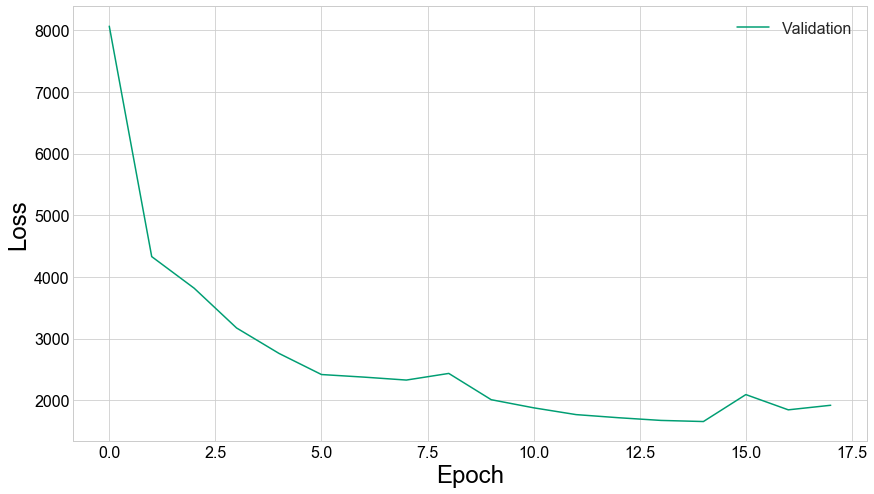

Mean loss = 1655.169921875±0.0
Mean Pull = 39.46874912904867±0.0
______________________________________



<Figure size 432x288 with 0 Axes>

In [67]:
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       train_params=train_params,
                                                       use_callbacks=use_callbacks,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience,
                                                       plots=plots)

In [ ]:
ensemble = Ensemble()
ensemble.build_ensemble(results, ensemble_size, model_builder)

In [ ]:
ensemble.save('weights/test', feats=train_feats, overwrite=True)

## Interpretation 

In [ ]:
ensemble = Ensemble()
ensemble.load('weights/test')

In [ ]:
with open(PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)
train_fy.add_input_pipe(input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True); train_df.head()

In [ ]:
from lumin.nn.interpretation.features import get_ensemble_feat_importance, get_nn_feat_importance

In [ ]:
ensemble.get_feat_importance(train_fy)

## Validation 

In [ ]:
ensemble = Ensemble()
ensemble.load('weights/test')

In [ ]:
val_fy = FoldYielder(h5py.File(PATH/'val.hdf5', "r+"), cont_feats, cat_feats, ignore_feats=ignore_feats,
                     input_pipe=input_pipe)

In [ ]:
ensemble.predict(val_fy)

In [ ]:
df = val_fy.get_df(inc_inputs=True, deprocess=True)

In [ ]:
df.head()

In [ ]:
reg_proxy_func(df)

In [ ]:
df['reco_delta'] = df['h_tt_mass']-df['gen_target']
df['pred_delta'] = df['pred']-df['gen_target']
df['reco_pull'] = df['reco_delta']/df['gen_target']
df['pred_pull'] = df['pred_delta']/df['gen_target']

In [ ]:
from lumin.utils.statistics import bootstrap_stats
x = np.linspace(0, 300, 500)
x_delta = np.linspace(-50, 200, 500)
x_pull = np.linspace(-1, 1, 500)

bs_stats = mp_run([{'data':df.h_tt_mass, 'name':'reco', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred, 'name':'pred', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_delta, 'name':'reco_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_pull, 'name':'reco_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_delta, 'name':'pred_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_pull, 'name':'pred_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1}], bootstrap_stats)

In [ ]:
plot_kdes_from_bs(x, {s:bs_stats[s] for s in bs_stats if 'reco' in s or 'gen' in s or 'pred' in s},
                  {'reco': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$M_{h\rightarrow\tau\tau}$', units='GeV')

In [ ]:
plot_kdes_from_bs(x_delta, {s:bs_stats[s] for s in bs_stats if 'delta' in s},
                  {'reco_delta': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_delta': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{h\rightarrow\tau\tau}$', units='GeV')

In [ ]:
plot_kdes_from_bs(x_pull, {s:bs_stats[s] for s in bs_stats if 'pull' in s},
                  {'reco_pull': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_pull': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{h\rightarrow\tau\tau}/M_{h\rightarrow\tau\tau, \mathrm{gen.}}$')